In [1]:
import sys
import pickle
import pandas as pd
path:str = '/Users/juanbeta/My Drive/Research/Energy/E-CVRP-TW/Code/'
#path: str = 'C:/Users/jm.betancourt/Documents/Research/Energy//E-CVRP-TW/Code/'

from E_CVRP_TW import  E_CVRP_TW, Feasibility
env = E_CVRP_TW(path)

sys.path.insert(0,path+'Experimentation/')
import plot_performance as plot

# Constructive

### Alpha configuration

Testing various alpha configurations

In [2]:
alphas = [0.15, 0.3, 0.5, 'Adaptative-Reactive']
data_alpha = {}
for instance in env.instances:
    data_alpha[instance] = {}
    for alpha in alphas:
        data_alpha[instance][alpha] = plot.retrieve_const_performance(instance, path+f'Experimentation/Constructive/alpha/{alpha}/')

In [3]:
print(' \t \t \t0.15 \t \t \t \t \t0.3 \t \t \t \t \t0.5 \t \t \t \t \tA-R')
print('Instance \tM \tEV \tFO \tgap \ts \t \tEV \tFO \tgap \ts \t \tEV \tFO \tgap \ts \t \tEV \tFO \tgap \ts')

for instance in env.instances[:10]:
    env.load_data(instance)
    things = [instance, len(env.Costumers)]
    for alpha in alphas:
        things += [len(data_alpha[instance][alpha]['best individual']),
                    round(data_alpha[instance][alpha]['best distance'],2),
                    data_alpha[instance][alpha]['gap'],
                    round(data_alpha[instance][alpha]['time to find'],2),
                    ' ']
    print(*things,sep = '\t')

 	 	 	0.15 	 	 	 	 	0.3 	 	 	 	 	0.5 	 	 	 	 	A-R
Instance 	M 	EV 	FO 	gap 	s 	 	EV 	FO 	gap 	s 	 	EV 	FO 	gap 	s 	 	EV 	FO 	gap 	s
c101C10.txt	10	4	446.26	13.33	0.05	 	4	446.26	13.33	0.02	 	4	446.26	13.33	0.09	 	4	446.26	13.33	0.02	 
c101C5.txt	5	3	250.04	-2.99	0.0	 	3	250.04	-2.99	0.0	 	3	250.04	-2.99	0.0	 	3	250.04	-2.99	0.0	 
c101_21.txt	100	20	1974.81	87.39	291.86	 	25	2177.8	106.66	147.62	 	24	2386.12	126.42	314.32	 	19	1978.33	87.73	285.96	 
c102_21.txt	100	21	1909.41	80.74	293.19	 	22	2164.92	104.92	351.44	 	22	2362.55	123.63	91.18	 	21	1933.55	83.02	193.59	 
c103C15.txt	15	4	437.79	13.92	2.58	 	5	426.56	11.0	37.59	 	3	409.81	6.64	26.22	 	5	426.56	11.0	24.92	 
c103C5.txt	5	2	165.67	-5.9	0.0	 	2	165.67	-5.9	0.0	 	2	165.67	-5.9	0.0	 	2	165.67	-5.9	0.02	 
c103_21.txt	100	18	1799.87	79.62	116.82	 	19	1951.41	94.75	125.52	 	20	2121.89	111.76	220.37	 	17	1719.19	71.57	449.53	 
c104C10.txt	10	2	281.8	2.87	0.28	 	2	281.8	2.87	0.36	 	2	279.93	2.19	6.96	 	2	279.93	2.19	2.07	 
c104_21.txt

In [4]:
instance = env.sizes['l'][20]
alpha = 0.5

print(f'########## Performance ##########')
print(f'incumbent: {round(data_alpha[instance][alpha]["best distance"],2)}')
print(f'gap: {round((data_alpha[instance][alpha]["best distance"] - env.bkFO[instance])/env.bkFO[instance]*100,2)}%')
print(f'time to find: {round(data_alpha[instance][alpha]["time to find"],2)}')

########## Performance ##########
incumbent: 2009.52
gap: 84.63%
time to find: 266.16


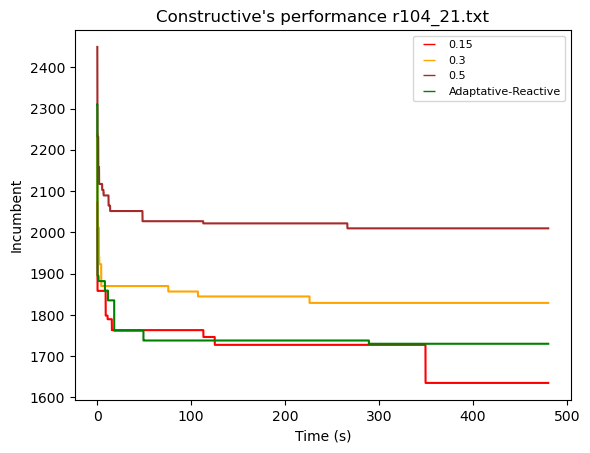

In [5]:
plot.plot_const_performance(data_alpha[instance],instance, objective = False)

### Restrictive criterion

Testing various restriction configuration for the RCL

In [7]:
criterions = ['distance', 'TimeWindow','Intra-Hybrid', 'Exo-Hybrid']
data_crit = dict()
for instance in env.instances:
    data_crit[instance] = dict()
    for criterion in criterions:
        data = plot.retrieve_const_performance(instance, path+f'Experimentation/Constructive/RCL criterion/{criterion}/')
        data_crit[instance][criterion] = dict() 
        data_crit[instance][criterion]['min_dist'] = data[0]
        data_crit[instance][criterion]['min_EV'] = data[1]

In [8]:
print(' \t \t \tDist \t \t \t \t \tTW \t \t \t \t \tIntra-H \t \t \t \t \tExo-H')
print('Instance \tM \tEV \tFO \tgap \ts \t \tEV \tFO \tgap \ts \t \tEV \tFO \tgap \ts \t \tEV \tFO \tgap \ts')

objective = 'min_EV'

for instance in env.sizes['l'][:10]:
    env.load_data(instance)
    things = [instance, len(env.Costumers)]
    for criterion in criterions:
        things += [len(data_crit[instance][criterion][objective]['best individual']),
                    round(data_crit[instance][criterion][objective]['best distance'],2),
                    data_crit[instance][criterion][objective]['gap'],
                    round(data_crit[instance][criterion][objective]['time to find'],2),
                    ' ']
    print(*things,sep = '\t')

 	 	 	Dist 	 	 	 	 	TW 	 	 	 	 	Intra-H 	 	 	 	 	Exo-H
Instance 	M 	EV 	FO 	gap 	s 	 	EV 	FO 	gap 	s 	 	EV 	FO 	gap 	s 	 	EV 	FO 	gap 	s
c101_21.txt	100	22	2258.7	114.33	62.42	 	16	2038.53	93.44	36.22	 	19	1978.33	87.73	354.64	 	18	2125.15	101.66	98.86	 
c102_21.txt	100	21	2183.79	106.71	308.44	 	17	2005.05	89.79	381.81	 	18	2079.12	96.8	91.5	 	18	1987.39	88.12	358.57	 
c103_21.txt	100	19	1896.92	89.31	417.94	 	17	1950.72	94.68	268.09	 	17	1865.52	86.17	377.33	 	17	1755.95	75.24	378.63	 
c104_21.txt	100	14	1539.01	57.12	294.73	 	15	1934.51	97.5	237.42	 	15	1676.83	71.19	384.39	 	14	1649.42	68.39	9.37	 
c105_21.txt	100	20	2138.44	98.86	439.77	 	15	1892.39	75.98	326.41	 	18	1978.79	84.01	366.05	 	17	2031.35	88.9	19.1	 
c106_21.txt	100	18	2035.81	92.43	328.38	 	16	1966.03	85.83	143.59	 	18	1991.7	88.26	440.61	 	17	2124.84	100.84	331.29	 
c107_21.txt	100	19	2100.36	103.61	353.69	 	15	1838.52	78.23	339.47	 	17	2095.23	103.11	447.81	 	16	2015.68	95.4	49.48	 
c108_21.txt	100	17	1709.49	68.3	1

In [9]:
instance = env.sizes['l'][4]
criterion = 'TimeWindow'
objective = 'min_EV'

print(f'########## Performance ##########')
print(f'incumbent: {round(data_crit[instance][criterion][objective]["best distance"],2)}')
print(f'gap: {round((data_crit[instance][criterion][objective]["best distance"] - env.bkFO[instance])/env.bkFO[instance]*100,2)}%')
print(f'time to find: {round(data_crit[instance][criterion][objective]["time to find"],2)}')

########## Performance ##########
incumbent: 1892.39
gap: 75.98%
time to find: 326.41


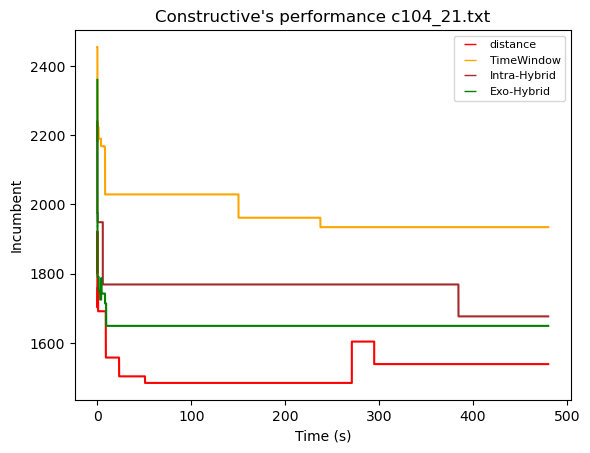

In [14]:
instance = env.sizes['l'][3]
plot.plot_const_performance(data_crit[instance],instance, objective = 'min_EV')

# Operators

## Darwinian phi rate

In [2]:
operators = ['Darwinian phi rate', 'evaluated insertion']
configurations = {'Darwinian phi rate':['regular', 'exponential'],
                  'evaluated insertion':['phi rate']}#['Hybrid', 'phi rate', 'visited costumers']}
data_op = dict()

for instance in env.instances:
    if instance != 'c108_21.txt':
        data_op[instance] = dict()
        for operator in operators:
            data_op[instance][operator] = dict()
            for config in configurations[operator]:
                data_op[instance][operator][config] = plot.retrieve_const_performance(instance, path+f'Experimentation/Operators/{operator}/{config}/')

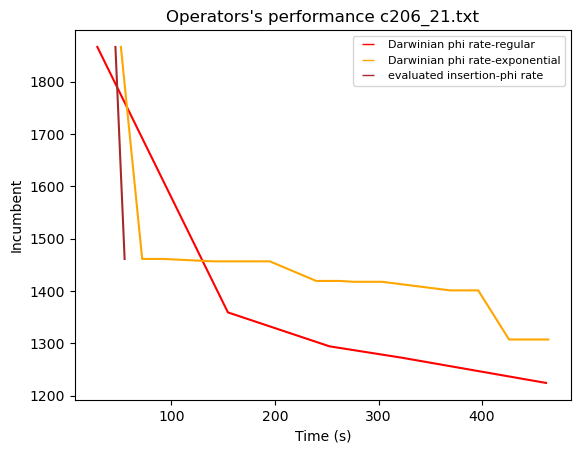

In [3]:
instance = env.sizes['l'][14]
plot.plot_op_performance(data_op[instance],instance, objective = 'min_EV')

In [4]:
##### Export data to Excel
data = data_op
list_idx = 2

d = {'instance': [], 'M':[]}#, 'const/#EV':[], 'const/FO':[], 'const/t':[]}
for instance in env.instances:
    if instance != 'c108_21.txt':
        env.load_data(instance)
        d['instance'].append(instance)
        d['M'].append(len(env.Costumers))

    # d['const/#EV'].append(len(data_op[instance][operator][config][0]['best individual']))
    # d['const/FO'].append(round(data_op[instance][operator][config][0]['best distance'],2))
    # d['const/EV'].append()



for operator in operators:
    for config in configurations[operator]:
        d[f'{operator}-{config}/# EV'] = [len(data_op[instance][operator][config][list_idx]['best individual']) for instance in env.instances if instance != 'c108_21.txt']
        d[f'{operator}-{config}/FO'] = [round(data_op[instance][operator][config][list_idx]['best distance'],2) for instance in env.instances if instance != 'c108_21.txt']
        # d[f'{criterion}/gap'] = [data[instance][criterion]['gap'] for instance in env.instances]
        d[f'{operator}-{config}/t'] = [round(data_op[instance][operator][config][list_idx]['time to find'],2) for instance in env.instances if instance != 'c108_21.txt']

df = pd.DataFrame(data = d)
df.to_excel('oppp-results.xlsx')

In [10]:
configurations


{'Darwinian phi rate': ['regular', 'exponential'],
 'evaluated insertion': ['phi rate']}

In [ ]:
##### Export data to Excel
data = data_crit 

d = {'instance': [], 'M':[]}
for instance in env.instances:
    env.load_data(instance)
    d['instance'].append(instance)
    d['M'].append(len(env.Costumers))

for criterion in criterions:
    d[f'{criterion}/# EV'] = [len(data[instance][criterion]['best individual']) for instance in env.instances]
    d[f'{criterion}/FO'] = [round(data[instance][criterion]['best distance'],2) for instance in env.instances]
    # d[f'{criterion}/gap'] = [data[instance][criterion]['gap'] for instance in env.instances]
    d[f'{criterion}/t'] = [round(data[instance][criterion]['time to find'],2) for instance in env.instances]

df = pd.DataFrame(data = d)
df.to_excel('criterions.xlsx')